# Universal Differential Equation for a 2D PDE heat equation

In [1]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate()
using Plots; gr()
using Statistics
using LinearAlgebra
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


### Parameter declaration

In [3]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.1
t₁ = 5

#D₀ = 1
tolnl = 1e-4
itMax = 20
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1;

In [4]:
function heatflow(T, fD::Function, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = fD(t)  # compute the diffusivity at each time
            # if iter == 1
            #     println("current D: ", D)
            # end
            
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 2 methods)

In [5]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

## Creating a reference dataset with a fake law

Let's assume that $D$ is a function of time

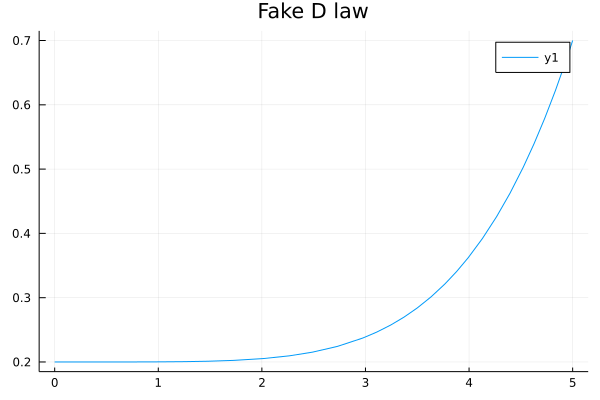

In [6]:
fakeD(t) = 0.1 * (2 + t^5 / t₁^4)

plot(fakeD, 0, t₁, title="Fake D law")

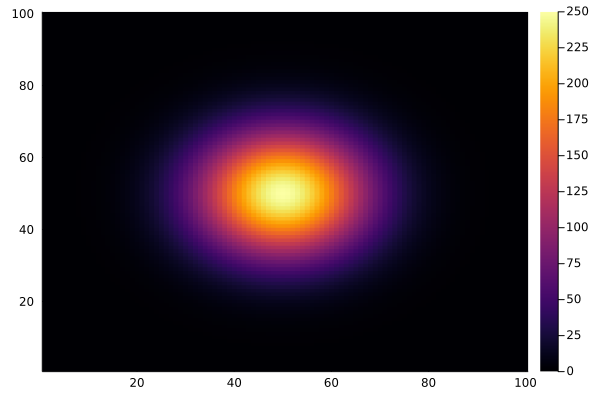

In [7]:
p = (Δx, Δy, Δt, t₁)

T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

T₁ = copy(T₀)
T₁ = heatflow(T₁, fakeD, p, 1e-2)

heatmap(T₀, clim=(0, maximum(T₀)))

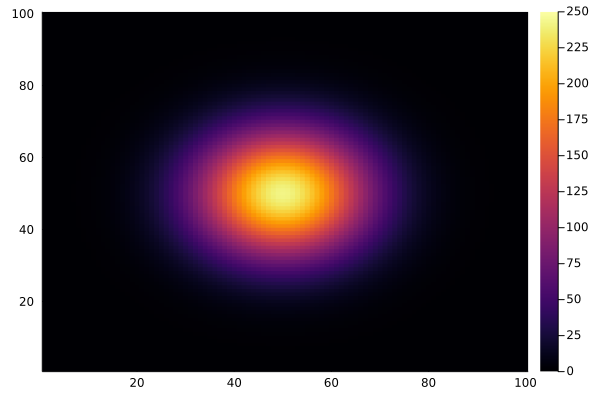

In [8]:
heatmap(T₁, clim=(0, maximum(T₀)))

In [10]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

1.1905659075860147

## Using a neural network to learn D

Now, let's try to reproduce `fakeD()` with a NN.

In [14]:
function heatflow_NN(T, uD, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = uD([t]')[1]  # compute the diffusivity at each time
            #println(D)
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow_NN (generic function with 2 methods)

In [15]:
sqnorm(x) = sum(abs2, x)

function loss(T, UD, p, λ=1)

    T = heatflow_NN(T, UD, p)
    l_cost = sqrt(Flux.Losses.mse(T, T₁; agg=mean))
    #l_reg  = sum(sqnorm, ps)

    return l_cost #+ λ * l_reg
end

loss (generic function with 2 methods)

In [26]:
# Patch suggested by Michael Abbott needed in order to correctly retrieve gradients
Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

function train(loss, p)
    
    leakyrelu(x, a=0.01) = max(a*x, x)
    relu(x) = max(0, x)
    sigmoid_D(x) = .5 + 10 / ( 1 + exp(-x) ) 

    #UD = Chain(
        #Dense(1,10,initb = Flux.zeros), 
        #BatchNorm(10, leakyrelu),
        #Dense(10,5,initb = Flux.zeros), 
        #BatchNorm(5, leakyrelu),
        #Dense(5,1, relu, initb = Flux.zeros) 
    #)
    UD = Chain(
        Dense(1,5,initb = Flux.glorot_normal), 
        Dense(5, 5, x->σ.(x), initb = Flux.glorot_normal),
        #BatchNorm(5, sigmoid),
        #Dense(5,1, sigmoid_D, initb = Flux.glorot_normal) 
        Dense(5, 1, x->σ.(x), initb = Flux.glorot_normal)
    )
    
    
    opt = ADAM(.1)
    #opt = Descent(0.1)
    
    losses = []
    @epochs 50 hybrid_train!(loss, UD, p, opt, losses)
    
    return UD, losses
    
end

function hybrid_train!(loss, UD, p, opt, losses)
    
    T = T₀
    θ = Flux.params(UD)
    loss_uD, back_uD = Zygote.pullback(() -> loss(T, UD, p), θ)
    push!(losses, loss_uD)
    
    println("Current loss: ", loss_uD)
    println("Current parameter:", θ)
    ∇_uD = back_uD(one(loss_uD))

    #for p in θ
    #    println("Gradients ∇_uD[p]: ", ∇_uD[p])
    #end
    
    #println("Values of NN: ", UD([0., .5, 1.]'))
    #all_times = LinRange(0, t₁, 1000)
    #plot(all_times, UD(all_times')')
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
    
end

hybrid_train! (generic function with 1 method)

In [27]:
UD_trained, losses = train(loss, p)

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6997037616187364
Current parameter:Params([Float32[0.63376117; 0.29353237; -0.59819984; -0.6504867; 0.25738955], Float32[-0.07180052, -0.5142198, -0.5363618, 0.29432756, -0.37299392], Float32[-0.6857432 -0.19293557 0.44693667 -0.29131866 0.3784663; 0.017878884 -0.68290526 0.22938293 0.565904 0.49102214; 0.05599352 0.28793204 0.33908975 -0.035517875 0.53997797; 0.26431927 0.6669036 0.19138502 0.0029890174 -0.11896972; 0.11726644 0.32301039 0.5665929 0.35402578 0.33874273], Float32[-0.14408235, 0.8329549, 0.07193283, -0.22124419, -0.9497147], Float32[0.6312492 0.62644863 0.7869804 -0.95487475 -0.9299102], Float32[-1.4303535]])


┌ Info: Epoch 2
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.054938280397298436
Current parameter:Params([Float32[0.5337612; 0.19353238; -0.49819988; -0.55048674; 0.35738954], Float32[-0.1718005, -0.6142198, -0.43636188, 0.39432728, -0.27299392], Float32[-0.58574325 -0.09293803 0.3469367 -0.39131862 0.47846597; 0.11787887 -0.5829054 0.12938294 0.46590403 0.591022; 0.15599352 0.38793197 0.23908976 -0.13551787 0.63997793; 0.16431928 0.56690365 0.29138502 0.10298901 -0.21896967; 0.017266471 0.22301124 0.66659284 0.45402575 0.238743], Float32[-0.04408238, 0.93295485, 0.17193282, -0.32124418, -1.0497147], Float32[0.73124915 0.72644866 0.8869804 -0.8548748 -0.8299102], Float32[-1.3303535]])


┌ Info: Epoch 3
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.40635186647634775
Current parameter:Params([Float32[0.43421972; 0.09359437; -0.4021131; -0.6120711; 0.4484028], Float32[-0.27192923, -0.71425426, -0.33667913, 0.32608458, -0.18004775], Float32[-0.496044 -0.16483021 0.25647435 -0.48051557 0.5556745; 0.21422398 -0.5867575 0.032843314 0.3696956 0.67343366; 0.2552069 0.37670356 0.14021052 -0.23489575 0.7266584; 0.06418687 0.5554378 0.391515 0.20310786 -0.3088146; -0.08247629 0.28874958 0.76663136 0.5534569 0.1518824], Float32[0.047388844, 1.0295167, 0.2696763, -0.42115235, -1.1497762], Float32[0.82262397 0.81945753 0.98107576 -0.75481284 -0.7301616], Float32[-1.2323502]])


┌ Info: Epoch 4
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.477876719720181
Current parameter:Params([Float32[0.3791522; 0.046534445; -0.3476411; -0.57894474; 0.46813175], Float32[-0.33242524, -0.7579434, -0.26300403, 0.35785535, -0.1683758], Float32[-0.46944964 -0.11323076 0.23728019 -0.48201796 0.5401232; 0.2660075 -0.5260446 -0.012946502 0.33471403 0.68663216; 0.3084997 0.43355763 0.0962873 -0.27004603 0.7358575; -0.0002281528 0.49682608 0.45052665 0.25699663 -0.3396056; -0.14568296 0.26169753 0.8209767 0.60230935 0.13710669], Float32[0.05296626, 1.0617964, 0.2949742, -0.4678007, -1.1894765], Float32[0.80866593 0.8245292 0.98967123 -0.70555586 -0.6970623], Float32[-1.2112995]])


┌ Info: Epoch 5
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.3762283868620759
Current parameter:Params([Float32[0.3386752; 0.017888647; -0.30372357; -0.5198273; 0.4564304], Float32[-0.38306615, -0.78184795, -0.18620166, 0.4166807, -0.19023466], Float32[-0.46692172 -0.04156163 0.24623476 -0.45452884 0.4951517; 0.298816 -0.4496566 -0.0358625 0.32463515 0.67170644; 0.34006086 0.50795704 0.079747155 -0.27504188 0.7107049; -0.047668304 0.42242447 0.48911768 0.2892717 -0.34321076; -0.19090341 0.20511658 0.8507089 0.6249574 0.15702808], Float32[0.025406417, 1.0638372, 0.28501248, -0.48684794, -1.195738], Float32[0.7622858 0.79401076 0.963027 -0.68426085 -0.7002067], Float32[-1.2261764]])


┌ Info: Epoch 6
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.1672023803119683
Current parameter:Params([Float32[0.30183962; -0.006766204; -0.25919968; -0.44705263; 0.42472205], Float32[-0.4350537, -0.8014725, -0.101849824, 0.4892293, -0.23159686], Float32[-0.4779184 0.039954152 0.27142993 -0.41199437 0.4344776; 0.32070437 -0.36514598 -0.04473377 0.32828388 0.64019; 0.3576898 0.59117997 0.08130183 -0.26130414 0.6645731; -0.084522754 0.3393265 0.5141389 0.30821982 -0.32877007; -0.22463137 0.13288206 0.86223125 0.6296989 0.2004658], Float32[-0.021415846, 1.0459273, 0.25218707, -0.485877, -1.1761134], Float32[0.6998355 0.74361366 0.91689634 -0.6840674 -0.7300669], Float32[-1.262928]])


┌ Info: Epoch 7
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.10961907895834558
Current parameter:Params([Float32[0.2592528; -0.038766615; -0.20358086; -0.36573908; 0.37882125], Float32[-0.49480477, -0.82824695, -0.012995291, 0.5700931, -0.28528985], Float32[-0.49667147 0.12748627 0.30625406 -0.36185655 0.36465374; 0.33570018 -0.2755284 -0.04418527 0.33983538 0.5975983; 0.365247 0.679779 0.09575403 -0.2351676 0.6043615; -0.11393655 0.25071883 0.5289081 0.31800482 -0.29996338; -0.24961306 0.051976454 0.85791147 0.62004894 0.26163226], Float32[-0.08056218, 1.0132556, 0.20322785, -0.4679981, -1.1345258], Float32[0.6282399 0.6807365 0.8590386 -0.7019867 -0.78066564], Float32[-1.3142923]])


┌ Info: Epoch 8
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.24415998808667108
Current parameter:Params([Float32[0.24802272; -0.04340431; -0.20295087; -0.3330366; 0.35902703], Float32[-0.5178113, -0.83132243, 0.0029657457, 0.6075298, -0.3133114], Float32[-0.5081645 0.16685234 0.3274779 -0.3267339 0.32305375; 0.35064283 -0.23761262 -0.04943588 0.34505808 0.57550746; 0.37691855 0.7129358 0.09826866 -0.22292748 0.57819456; -0.14092956 0.22183402 0.54743713 0.33103624 -0.2932242; -0.2743964 0.042252425 0.8686475 0.62412345 0.27021462], Float32[-0.11021325, 1.0028446, 0.18547882, -0.47155818, -1.134837], Float32[0.5882486 0.65134364 0.8277449 -0.6971329 -0.78504854], Float32[-1.3355963]])


┌ Info: Epoch 9
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.24179224426085083
Current parameter:Params([Float32[0.262915; -0.026074884; -0.23294699; -0.32970482; 0.35738298], Float32[-0.5133281, -0.81538326, -0.01515434, 0.61834574, -0.32404023], Float32[-0.5146007 0.17776075 0.33849725 -0.30142903 0.30032918; 0.36536646 -0.23060578 -0.05935542 0.34620672 0.5683416; 0.3915639 0.714697 0.09142631 -0.21978107 0.5742929; -0.16584405 0.22559753 0.5691183 0.34572148 -0.3022429; -0.29888874 0.06451846 0.89127725 0.6363245 0.25093916], Float32[-0.120183855, 1.0083694, 0.18855515, -0.4904117, -1.1594023], Float32[0.56931 0.6447068 0.8148931 -0.67614573 -0.76350486], Float32[-1.3361033]])


┌ Info: Epoch 10
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.1511871676499892
Current parameter:Params([Float32[0.2966213; 0.007050389; -0.27923208; -0.34522623; 0.3697022], Float32[-0.4884325, -0.7851845, -0.05261039, 0.6108832, -0.321087], Float32[-0.5159466 0.16982259 0.33996537 -0.28380746 0.2920373; 0.38053772 -0.24394351 -0.074155524 0.34421554 0.5729439; 0.4097858 0.6964217 0.07543858 -0.22365408 0.58670956; -0.18938072 0.24866739 0.59398055 0.36109778 -0.3222091; -0.32360712 0.10366916 0.9235834 0.65221626 0.2164031], Float32[-0.1151482, 1.0264826, 0.20729123, -0.5203844, -1.1988072], Float32[0.5663016 0.65553945 0.8171814 -0.64333546 -0.7260758], Float32[-1.3205502]])


┌ Info: Epoch 11
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.030057553854281813
Current parameter:Params([Float32[0.34331045; 0.051137198; -0.3336786; -0.37333986; 0.39335364], Float32[-0.44808257, -0.7443845, -0.102194645, 0.5899337, -0.30617], Float32[-0.5109151 0.14868712 0.33138746 -0.2731883 0.29604372; 0.39727166 -0.2712407 -0.094524845 0.33938313 0.5874261; 0.43295643 0.6647745 0.04990262 -0.23361203 0.6119144; -0.21225955 0.28343 0.62200874 0.37654766 -0.34957445; -0.3489799 0.15194997 0.9633816 0.66866857 0.17375848], Float32[-0.097513884, 1.055221, 0.23866183, -0.5585232, -1.2475684], Float32[0.57644314 0.68085253 0.8333717 -0.60158753 -0.67831534], Float32[-1.2916919]])


┌ Info: Epoch 12
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.12604154465995343
Current parameter:Params([Float32[0.3978611; 0.101946786; -0.3902187; -0.4097322; 0.42596743], Float32[-0.39661315, -0.6964666, -0.15910465, 0.5590927, -0.2808603], Float32[-0.49727473 0.11869207 0.31198275 -0.2699808 0.31149676; 0.41688117 -0.30750355 -0.120916344 0.33158293 0.6104389; 0.46214643 0.6249408 0.0152400825 -0.24892433 0.6469762; -0.2349952 0.32440507 0.65265995 0.39173117 -0.3815213; -0.37512606 0.20411791 1.0081247 0.68403244 0.12768258], Float32[-0.0690387, 1.0927011, 0.2798859, -0.60207695, -1.3015896], Float32[0.5976401 0.7182058 0.8625609 -0.5535395 -0.62423646], Float32[-1.251858]])


┌ Info: Epoch 13
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.20065692844304386
Current parameter:Params([Float32[0.43656066; 0.13810761; -0.43732652; -0.43204615; 0.4437157], Float32[-0.36751533, -0.66375065, -0.1977959, 0.5432152, -0.2709048], Float32[-0.498539 0.10084163 0.30961475 -0.25884148 0.31124142; 0.42828712 -0.3303244 -0.13514422 0.3286379 0.6204109; 0.47856313 0.5984215 -0.0028021208 -0.2567179 0.6660877; -0.2530502 0.3540824 0.6751098 0.40427035 -0.40409705; -0.3952838 0.24465811 1.0402634 0.69784325 0.09201762], Float32[-0.057877515, 1.1136692, 0.30293512, -0.6327559, -1.3410617], Float32[0.6038059 0.73438495 0.8707638 -0.5209731 -0.58642], Float32[-1.2325202]])


┌ Info: Epoch 14
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.20705006160850287
Current parameter:Params([Float32[0.4650219; 0.16393127; -0.47918218; -0.4437492; 0.44971338], Float32[-0.3548436, -0.6420888, -0.22340092, 0.53894305, -0.2735498], Float32[-0.5143754 0.09124232 0.32284644 -0.2398452 0.29734936; 0.4316614 -0.34363782 -0.13827188 0.33023354 0.6194002; 0.48402324 0.5813193 -0.0070984145 -0.2585923 0.6731335; -0.2671041 0.3757712 0.6908356 0.4147368 -0.41970372; -0.41068435 0.27683157 1.0627933 0.7107876 0.06370237], Float32[-0.06114776, 1.1210982, 0.31176198, -0.6535252, -1.3697594], Float32[0.597576 0.7332152 0.8613209 -0.5005495 -0.56085235], Float32[-1.2300074]])


┌ Info: Epoch 15
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.16184267053231446
Current parameter:Params([Float32[0.48596781; 0.1818879; -0.5183683; -0.44742996; 0.44625998], Float32[-0.35485545, -0.6288896, -0.23950712, 0.543658, -0.28647378], Float32[-0.542739 0.087257504 0.34933797 -0.21409337 0.2726347; 0.42730144 -0.34991688 -0.13113806 0.33603862 0.6090903; 0.47992814 0.5712647 0.0003635066 -0.25564876 0.67072356; -0.27773818 0.391363 0.7008601 0.42358747 -0.43000078; -0.42232323 0.30251414 1.0776459 0.7233572 0.04077605], Float32[-0.076097324, 1.1171405, 0.309067, -0.66629946, -1.3900199], Float32[0.58144224 0.71773124 0.83731115 -0.4900313 -0.54497564], Float32[-1.2414844]])


┌ Info: Epoch 16
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.08491092722652549
Current parameter:Params([Float32[0.50005525; 0.19349226; -0.55632424; -0.44521424; 0.43509457], Float32[-0.36525825, -0.62244016, -0.24877185, 0.5551889, -0.30775028], Float32[-0.5807819 0.0871732 0.38636747 -0.18339433 0.240197; 0.41541055 -0.35084894 -0.114273 0.34582442 0.5907857; 0.46718037 0.5666557 0.018311504 -0.24855164 0.660631; -0.28540105 0.4020476 0.705867 0.43117556 -0.43618459; -0.43094355 0.32292625 1.0861162 0.73589045 0.021883853], Float32[-0.10013822, 1.1033615, 0.29675147, -0.67237556, -1.4034247], Float32[0.557685 0.69035244 0.80133253 -0.4878225 -0.53699815], Float32[-1.2647272]])


┌ Info: Epoch 17
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.012189804170596492
Current parameter:Params([Float32[0.50638276; 0.19970585; -0.59357566; -0.43888983; 0.41752964], Float32[-0.38484067, -0.62155944, -0.25307617, 0.57174504, -0.33583692], Float32[-0.62536407 0.090002984 0.4311534 -0.14993681 0.20314921; 0.39611137 -0.34759286 -0.08792424 0.3594412 0.5655423; 0.446346 0.5663667 0.045999113 -0.23767985 0.6441329; -0.29045567 0.40856853 0.70627385 0.43780908 -0.43919268; -0.43715745 0.33888233 1.0890675 0.7486983 0.005992776], Float32[-0.13090335, 1.080864, 0.27615428, -0.67261064, -1.4110545], Float32[0.5282791 0.6530454 0.75556666 -0.49280295 -0.5356598], Float32[-1.2979612]])


┌ Info: Epoch 18
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05950730629461586
Current parameter:Params([Float32[0.5207511; 0.20956951; -0.6242831; -0.43642488; 0.40904894], Float32[-0.3915593, -0.6161071, -0.25987473, 0.58158475, -0.3524238], Float32[-0.6569734 0.08998352 0.4606802 -0.12359705 0.17525549; 0.3883841 -0.34824437 -0.07749315 0.36656165 0.55178124; 0.43795788 0.5627282 0.057481047 -0.23264568 0.6364976; -0.29689723 0.41747373 0.7109745 0.44395658 -0.44407108; -0.44412488 0.35566455 1.0963316 0.75866926 -0.0091410605], Float32[-0.15065578, 1.0713124, 0.26731694, -0.6779902, -1.4221258], Float32[0.5088236 0.6332016 0.7294634 -0.4905236 -0.52900726], Float32[-1.3145857]])


┌ Info: Epoch 19
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.06948390874871271
Current parameter:Params([Float32[0.5434682; 0.22253278; -0.6493009; -0.4367326; 0.40839276], Float32[-0.38681793, -0.606881, -0.26843423, 0.5861399, -0.35928062], Float32[-0.6785346 0.08776733 0.478204 -0.10256753 0.15414971; 0.39155012 -0.3517598 -0.08153491 0.36769053 0.5479879; 0.44102022 0.5566155 0.054543078 -0.23290792 0.6364504; -0.30459517 0.42828432 0.71956193 0.44956696 -0.4502979; -0.45162526 0.37298802 1.1072528 0.7659443 -0.023245323], Float32[-0.16165625, 1.0730816, 0.2686308, -0.68779945, -1.4360019], Float32[0.49744126 0.62817717 0.7198878 -0.4820055 -0.5179226], Float32[-1.3169949]])


┌ Info: Epoch 20
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04385128791705611
Current parameter:Params([Float32[0.57395446; 0.23790303; -0.66994935; -0.43908954; 0.41434565], Float32[-0.3719105, -0.59464425, -0.27874583, 0.5863908, -0.35784286], Float32[-0.6918138 0.08390019 0.4860102 -0.085648514 0.13837549; 0.40469736 -0.357183 -0.09807225 0.36361682 0.55269367; 0.45432225 0.5487507 0.039348297 -0.23759173 0.6427501; -0.31343934 0.44054398 0.73151517 0.45457396 -0.45747405; -0.45958596 0.39060396 1.1212054 0.77068996 -0.036212213], Float32[-0.1654827, 1.0845648, 0.27862662, -0.7013525, -1.4521474], Float32[0.49277607 0.6359281 0.7245378 -0.46813536 -0.5031123], Float32[-1.3071581]])


┌ Info: Epoch 21
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.0009454036345114184
Current parameter:Params([Float32[0.61117136; 0.25495037; -0.68784654; -0.4430587; 0.42576367], Float32[-0.34793282, -0.58004403, -0.29129785, 0.58295804, -0.3492382], Float32[-0.6978778 0.07879026 0.4857035 -0.07198413 0.12700915; 0.4267225 -0.36378503 -0.124958925 0.3553651 0.5644849; 0.47654817 0.53962004 0.014067025 -0.2455774 0.6542188; -0.323358 0.45386556 0.7463067 0.45891067 -0.46532494; -0.4680839 0.40830788 1.1376698 0.7731042 -0.048070043], Float32[-0.16319974, 1.1042876, 0.29606268, -0.7180575, -1.4701399], Float32[0.49387658 0.6549239 0.7417319 -0.44962007 -0.48511165], Float32[-1.2866311]])


┌ Info: Epoch 22
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05220841134388934
Current parameter:Params([Float32[0.64899725; 0.27155346; -0.7042803; -0.44739264; 0.43850467], Float32[-0.3215166, -0.5654128, -0.304499, 0.5782916, -0.3383606], Float32[-0.7007786 0.073551506 0.48239243 -0.06015616 0.117872864; 0.45107102 -0.37033433 -0.15425141 0.3462125 0.57819223; 0.50104934 0.53054565 -0.013583826 -0.25406122 0.6668739; -0.33319077 0.4668227 0.76133066 0.4627038 -0.47296774; -0.47641093 0.4250753 1.1541723 0.77445805 -0.058868825], Float32[-0.15871227, 1.1260649, 0.3154109, -0.7350396, -1.4878621], Float32[0.4971089 0.6775343 0.7632039 -0.4302774 -0.46682027], Float32[-1.2628552]])


┌ Info: Epoch 23
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.08344232345952383
Current parameter:Params([Float32[0.67466235; 0.2846184; -0.7180564; -0.44982016; 0.44526353], Float32[-0.30836177, -0.55486697, -0.31168073, 0.577446, -0.33516863], Float32[-0.70950514 0.06988355 0.48602042 -0.04821515 0.10690088; 0.4634378 -0.3753735 -0.17032248 0.34092218 0.5844541; 0.5136435 0.5238589 -0.028562592 -0.259796 0.6738498; -0.34033173 0.47696018 0.77175826 0.46658024 -0.47891313; -0.4825696 0.4389986 1.1660143 0.77758914 -0.06869681], Float32[-0.1599638, 1.137477, 0.3252944, -0.7467321, -1.5011297], Float32[0.49515048 0.6851383 0.7683927 -0.418204 -0.454391], Float32[-1.2534748]])


┌ Info: Epoch 24
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.06705956371374643
Current parameter:Params([Float32[0.68988794; 0.29476914; -0.7288794; -0.4506114; 0.44694942], Float32[-0.30691078, -0.54777616, -0.3129039, 0.58002067, -0.3387492], Float32[-0.7233332 0.06754329 0.49559703 -0.036437303 0.09446853; 0.4654492 -0.37922552 -0.1752257 0.33867615 0.5844627; 0.5159991 0.5192417 -0.03281913 -0.26356313 0.6760972; -0.34505334 0.4846522 0.77816427 0.4706135 -0.48342907; -0.48674208 0.45041627 1.1737621 0.7823894 -0.077695206], Float32[-0.16626911, 1.1398919, 0.32688314, -0.7537556, -1.5104455], Float32[0.4885887 0.67950535 0.7593178 -0.41265026 -0.44723782], Float32[-1.2567862]])


┌ Info: Epoch 25
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03375131887399373
Current parameter:Params([Float32[0.6958389; 0.30248576; -0.73669195; -0.45002106; 0.44422907], Float32[-0.31555814, -0.54354835, -0.30870232, 0.58553857, -0.34819165], Float32[-0.7413889 0.06627244 0.510114 -0.025008034 0.08097604; 0.4582614 -0.38237092 -0.17039807 0.3391065 0.5789979; 0.50939924 0.5162447 -0.027841687 -0.26568884 0.674279; -0.34758464 0.49027264 0.78101444 0.47479102 -0.48670658; -0.4891224 0.45966303 1.1779327 0.78864795 -0.0859693], Float32[-0.17684567, 1.1344769, 0.32129255, -0.7566847, -1.5163127], Float32[0.47808895 0.66238236 0.7379458 -0.41282785 -0.4447095], Float32[-1.2711575]])


┌ Info: Epoch 26
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.01824774852455429
Current parameter:Params([Float32[0.6931756; 0.3081432; -0.7414708; -0.4482379; 0.43751737], Float32[-0.33310264, -0.5416696, -0.2995761, 0.59365535, -0.36284608], Float32[-0.76278394 0.0659181 0.5287098 -0.014113865 0.066828646; 0.44262704 -0.38525873 -0.15669416 0.3420689 0.56855446; 0.4947832 0.51447827 -0.014616705 -0.26632148 0.66887397; -0.34809074 0.49407986 0.78057677 0.4791176 -0.48890492; -0.48987508 0.46698377 1.1788502 0.7962413 -0.093632355], Float32[-0.19105506, 1.1219813, 0.3093133, -0.7558635, -1.519064], Float32[0.464155 0.63523704 0.7059673 -0.41822466 -0.4463656], Float32[-1.2952665]])


┌ Info: Epoch 27
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04557980199314416
Current parameter:Params([Float32[0.6993001; 0.31454197; -0.74831843; -0.44780767; 0.43580374], Float32[-0.33917043, -0.5382762, -0.29646683, 0.59801584, -0.37004876], Float32[-0.77773124 0.06485401 0.54052293 -0.004504694 0.0555028; 0.43824485 -0.3873326 -0.15426737 0.34185296 0.5648105; 0.49047637 0.51224273 -0.011653251 -0.268419 0.66773635; -0.35041723 0.49879447 0.7833607 0.48254162 -0.49166852; -0.49194798 0.47472054 1.1826167 0.8012374 -0.10042177], Float32[-0.19960615, 1.1185083, 0.3053831, -0.75870854, -1.5241772], Float32[0.45576605 0.62279785 0.6904221 -0.41780087 -0.4438984], Float32[-1.3055514]])


┌ Info: Epoch 28
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04114180813036247
Current parameter:Params([Float32[0.71340555; 0.32149822; -0.7572213; -0.44855374; 0.43858874], Float32[-0.33516192, -0.53371614, -0.29880324, 0.5990482, -0.3706481], Float32[-0.7871707 0.0632093 0.54650706 0.0040562497 0.04654709; 0.44402295 -0.3883051 -0.161944 0.3386762 0.56711185; 0.49537295 0.50981265 -0.017783986 -0.27187094 0.67039067; -0.35440663 0.50425625 0.7890726 0.48513466 -0.49489632; -0.49517304 0.48279497 1.1889223 0.80385584 -0.10636076], Float32[-0.20325075, 1.1230876, 0.30856434, -0.76485634, -1.5313951], Float32[0.45225644 0.62322974 0.6891624 -0.4121487 -0.43773335], Float32[-1.3036737]])


┌ Info: Epoch 29
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.009121510738530745
Current parameter:Params([Float32[0.73453295; 0.3288863; -0.76826185; -0.45035496; 0.4453154], Float32[-0.3222041, -0.5281665, -0.3062596, 0.5970812, -0.36537686], Float32[-0.79175633 0.061066024 0.54739624 0.011774313 0.039636835; 0.45870247 -0.3881732 -0.17836069 0.33301452 0.57466435; 0.50839746 0.5072768 -0.03185633 -0.2763666 0.67633754; -0.35990334 0.5103357 0.797377 0.48694468 -0.49850005; -0.4994544 0.49113396 1.1974648 0.804312 -0.111507885], Float32[-0.20256054, 1.1347411, 0.31805193, -0.773929, -1.5404657], Float32[0.4530877 0.63507366 0.7004987 -0.4018181 -0.4282586], Float32[-1.2910157]])


┌ Info: Epoch 30
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.035258935297981936
Current parameter:Params([Float32[0.76159096; 0.3366209; -0.78154695; -0.45312393; 0.45537052], Float32[-0.30122438, -0.5216708, -0.31869578, 0.5923596, -0.35487264], Float32[-0.7919644 0.0584487 0.5437689 0.018855952 0.03452191; 0.4808685 -0.38721496 -0.20203088 0.325569 0.5865364; 0.5284444 0.50453967 -0.052725125 -0.2814005 0.68502337; -0.36673746 0.51694596 0.8079098 0.48798984 -0.5023879; -0.5047468 0.49967602 1.2079631 0.8028045 -0.115942985], Float32[-0.19795996, 1.1525003, 0.33315206, -0.7855526, -1.5511557], Float32[0.45783338 0.6571141 0.7230255 -0.38730147 -0.41581252], Float32[-1.2687701]])


┌ Info: Epoch 31
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05829362289896818
Current parameter:Params([Float32[0.7786769; 0.34269193; -0.79021746; -0.45454577; 0.46092597], Float32[-0.29160488, -0.5172882, -0.32394424, 0.5909762, -0.3509109], Float32[-0.7961534 0.056746557 0.5448177 0.025148619 0.02870619; 0.4926249 -0.38687003 -0.21531112 0.3204967 0.5928591; 0.5386531 0.50263935 -0.06389497 -0.2855281 0.6899492; -0.37123248 0.5219309 0.81475604 0.48959318 -0.5054009; -0.50818735 0.5065506 1.214959 0.8033458 -0.12023428], Float32[-0.19772069, 1.1617677, 0.3404969, -0.7929656, -1.558571], Float32[0.45821384 0.6652477 0.73051405 -0.37911028 -0.40824255], Float32[-1.2597624]])


┌ Info: Epoch 32
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05074883047583004
Current parameter:Params([Float32[0.7870898; 0.34727058; -0.7945757; -0.45473826; 0.4625667], Float32[-0.2921172, -0.5148593, -0.32248032, 0.5926421, -0.352799], Float32[-0.80393803 0.055880386 0.55003196 0.030639576 0.02229375; 0.49540523 -0.38696226 -0.21966977 0.3172713 0.5944544; 0.54020864 0.50155365 -0.06657795 -0.28908697 0.69161826; -0.3736296 0.5254672 0.8183478 0.49172878 -0.50765264; -0.50993437 0.5119334 1.218842 0.8057477 -0.12439409], Float32[-0.20141335, 1.1635785, 0.34091362, -0.79664093, -1.5630618], Float32[0.45465687 0.6609761 0.7246555 -0.37660077 -0.40507197], Float32[-1.2625573]])


┌ Info: Epoch 33
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.016638582914106113
Current parameter:Params([Float32[0.7877643; 0.35052446; -0.79490334; -0.45379496; 0.46071336], Float32[-0.30161494, -0.5141505, -0.3148524, 0.59710425, -0.35992756], Float32[-0.8148679 0.0557646 0.55890447 0.03533373 0.015411911; 0.4902387 -0.38749743 -0.21615316 0.31561843 0.5918841; 0.53406894 0.5011618 -0.06173965 -0.2922183 0.6904083; -0.37411657 0.5277099 0.8189979 0.4943663 -0.50923395; -0.5101397 0.51597273 1.2199146 0.809857 -0.12844847], Float32[-0.20860809, 1.1587473, 0.33513758, -0.79693186, -1.5649039], Float32[0.44756094 0.6457104 0.70704347 -0.37924448 -0.40590256], Float32[-1.2758464]])


┌ Info: Epoch 34
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.02759104291564125
Current parameter:Params([Float32[0.7813499; 0.35261315; -0.79144734; -0.45178112; 0.45565113], Float32[-0.31900772, -0.5148787, -0.30169263, 0.6041268, -0.37174016], Float32[-0.82847357 0.056288224 0.5709399 0.03927272 0.008187906; 0.4778309 -0.3886599 -0.20549585 0.3154816 0.5854905; 0.5209801 0.50123775 -0.050149474 -0.29487675 0.6865736; -0.37282252 0.52881694 0.8169245 0.4974555 -0.5102003; -0.50893354 0.5188088 1.2184199 0.8155179 -0.13241963], Float32[-0.21886383, 1.1479381, 0.32384306, -0.7941127, -1.5643332], Float32[0.43732017 0.620774 0.6791633 -0.3865713 -0.41036406], Float32[-1.2984254]])


┌ Info: Epoch 35
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05145205514523157
Current parameter:Params([Float32[0.7829151; 0.35535327; -0.7922314; -0.45118418; 0.45459366], Float32[-0.32593104, -0.5143489, -0.29599863, 0.6074702, -0.3770807], Float32[-0.8373523 0.056189116 0.5780294 0.04321067 0.0024819714; 0.47470966 -0.3886743 -0.20365426 0.3137503 0.5839486; 0.5169029 0.5011228 -0.04704424 -0.2977068 0.68592894; -0.37349084 0.5307256 0.8178653 0.4995856 -0.51158214; -0.5092567 0.52223384 1.2196208 0.8187079 -0.13572827], Float32[-0.22456488, 1.1447299, 0.31968394, -0.79477775, -1.5661331], Float32[0.4317826 0.60964745 0.66630346 -0.38816473 -0.4106329], Float32[-1.3080107]])


┌ Info: Epoch 36
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.0467278673819125
Current parameter:Params([Float32[0.79172313; 0.35865843; -0.7969445; -0.45190495; 0.4571883], Float32[-0.32358867, -0.5127808, -0.29705352, 0.6074552, -0.37662202], Float32[-0.84207255 0.055556618 0.58075655 0.047165632 -0.0019024669; 0.47998184 -0.38746732 -0.20975232 0.31051216 0.586826; 0.52094203 0.5009696 -0.05154046 -0.30076227 0.68818885; -0.3759645 0.5333314 0.8215681 0.50084084 -0.5133333; -0.5109441 0.52618724 1.2232646 0.81962526 -0.13840404], Float32[-0.22623062, 1.1483475, 0.32189196, -0.7986242, -1.5700927], Float32[0.4304574 0.61074466 0.6666766 -0.38455918 -0.40708795], Float32[-1.3060483]])


┌ Info: Epoch 37
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.02302370436619791
Current parameter:Params([Float32[0.8069583; 0.3624884; -0.80530494; -0.45384517; 0.46303535], Float32[-0.31293923, -0.5102365, -0.30430722, 0.6043612, -0.3709401], Float32[-0.8430457 0.054436486 0.5795722 0.051172297 -0.005110974; 0.49264374 -0.38519773 -0.22282358 0.30603617 0.5935815; 0.5322279 0.5007737 -0.06280142 -0.3039275 0.69303167; -0.38007447 0.53655696 0.8277465 0.50128853 -0.5154057; -0.51388025 0.5306092 1.229102 0.81847656 -0.14050193], Float32[-0.22425649, 1.1580418, 0.32982773, -0.805328, -1.5759943], Float32[0.43294185 0.62277037 0.6788334 -0.3762581 -0.40008816], Float32[-1.2937565]])


┌ Info: Epoch 38
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.02374856948530808
Current parameter:Params([Float32[0.8276963; 0.3668212; -0.81700355; -0.45688486; 0.47167236], Float32[-0.29481333, -0.50667447, -0.31730366, 0.59845775, -0.36056873], Float32[-0.8405979 0.052834846 0.5748528 0.055285383 -0.007262494; 0.5115748 -0.38221395 -0.24180907 0.30073485 0.6035696; 0.54983866 0.5003952 -0.079972506 -0.3069387 0.700074; -0.38561666 0.54034996 0.83606523 0.50097996 -0.51773536; -0.5179633 0.5354417 1.236871 0.8154716 -0.14208914], Float32[-0.21896036, 1.1730549, 0.34291053, -0.8145319, -1.5836078], Float32[0.43888512 0.6445964 0.7015233 -0.3637617 -0.38998693], Float32[-1.2722267]])


┌ Info: Epoch 39
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04562260647378898
Current parameter:Params([Float32[0.8399751; 0.3698881; -0.82357925; -0.45842272; 0.47643977], Float32[-0.28703222, -0.504873, -0.32244244, 0.59617823, -0.3563348], Float32[-0.841764 0.052031506 0.5742245 0.05848027 -0.00998774; 0.52177453 -0.3800107 -0.2523366 0.296717 0.6091963; 0.5586793 0.50050086 -0.08879892 -0.30992323 0.7040576; -0.38896385 0.5429219 0.84110177 0.50144947 -0.5194726; -0.5202824 0.53904134 1.2415713 0.8146842 -0.14384511], Float32[-0.21770906, 1.1806468, 0.34890872, -0.81993264, -1.5883578], Float32[0.44057405 0.6530235 0.70989746 -0.35730568 -0.38451463], Float32[-1.2634171]])


┌ Info: Epoch 40
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03267950690122339
Current parameter:Params([Float32[0.8448132; 0.37177587; -0.8255098; -0.458593; 0.47779414], Float32[-0.28857908, -0.50477934, -0.32035568, 0.5972187, -0.35764915], Float32[-0.84624135 0.051983584 0.57731336 0.060794964 -0.01323052; 0.52436465 -0.37833613 -0.2554741 0.29365832 0.61106074; 0.55972224 0.5011459 -0.09019985 -0.31305397 0.70534843; -0.39034894 0.5443797 0.8432227 0.5026401 -0.5206917; -0.5209971 0.54152405 1.2435217 0.81590974 -0.14574964], Float32[-0.22015609, 1.1816316, 0.34850287, -0.8219361, -1.5905329], Float32[0.43838388 0.6494215 0.7054612 -0.35630268 -0.38324034], Float32[-1.2660278]])


┌ Info: Epoch 41
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.007301933124709398
Current parameter:Params([Float32[0.84300137; 0.3725815; -0.8232186; -0.45750013; 0.47608805], Float32[-0.29835892, -0.5062353, -0.31179777, 0.6012705, -0.36390224], Float32[-0.8536684 0.052598394 0.5836964 0.062313404 -0.01692657; 0.5201952 -0.37716442 -0.25207093 0.29144773 0.6095701; 0.5537867 0.50223196 -0.08499715 -0.31629822 0.704204; -0.38995394 0.5448516 0.8427248 0.5044727 -0.52143604; -0.5202649 0.54300714 1.2430125 0.8189378 -0.14778545], Float32[-0.2258846, 1.1767613, 0.34240705, -0.82089716, -1.5904024], Float32[0.43273735 0.63514453 0.68969023 -0.36017334 -0.38572636], Float32[-1.2787946]])


┌ Info: Epoch 42
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03330569883080368
Current parameter:Params([Float32[0.83508456; 0.3723986; -0.8169945; -0.4551853; 0.47155195], Float32[-0.31548142, -0.5090411, -0.2973571, 0.60815275, -0.37463668], Float32[-0.86367655 0.053812604 0.5930003 0.0630854 -0.020988908; 0.5098903 -0.3765275 -0.24273016 0.29003283 0.6050222; 0.5415212 0.5036464 -0.0738136 -0.31960082 0.7008302; -0.3878901 0.5444226 0.8397731 0.5069065 -0.52174443; -0.51818866 0.54357105 1.2402126 0.8236475 -0.14995648], Float32[-0.23455507, 1.1665757, 0.33116794, -0.8170099, -1.5881238], Float32[0.42394838 0.6114161 0.66395104 -0.3685464 -0.39169186], Float32[-1.3006032]])


┌ Info: Epoch 43
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05545202360518627
Current parameter:Params([Float32[0.8345344; 0.37317356; -0.81569934; -0.45453992; 0.4705965], Float32[-0.3226503, -0.51021826, -0.29104286, 0.6110515, -0.37924117], Float32[-0.8695744 0.054304443 0.5979889 0.06438325 -0.02401196; 0.5073869 -0.37526542 -0.24077679 0.28797027 0.6042709; 0.5375963 0.504709 -0.07035375 -0.32246456 0.70025206; -0.38785067 0.54487973 0.8397645 0.5083472 -0.5224376; -0.5177666 0.5448873 1.2401166 0.8259045 -0.15158883], Float32[-0.23900309, 1.1632519, 0.32675236, -0.8165908, -1.5883111], Float32[0.41964966 0.60106504 0.6524877 -0.37111816 -0.39328665], Float32[-1.3097876]])


┌ Info: Epoch 44
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.0569351605532054
Current parameter:Params([Float32[0.84068894; 0.37482694; -0.8189259; -0.4554612; 0.47291923], Float32[-0.32097358, -0.5099776, -0.2920576, 0.61029387, -0.3783371], Float32[-0.8718201 0.05416063 0.5991384 0.066154 -0.02611704; 0.51194704 -0.37333825 -0.24549153 0.2852671 0.6069895; 0.5412163 0.50554794 -0.07384394 -0.32501757 0.7022476; -0.38967454 0.5461313 0.8424575 0.50888324 -0.52348226; -0.5188273 0.54689336 1.242483 0.82590103 -0.15270732], Float32[-0.23968567, 1.1660994, 0.32844344, -0.81934905, -1.5907578], Float32[0.41939187 0.60261583 0.6536842 -0.36842144 -0.39089516], Float32[-1.3077046]])


┌ Info: Epoch 45
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03426518820754129
Current parameter:Params([Float32[0.85277474; 0.3772898; -0.8262373; -0.4578058; 0.47815326], Float32[-0.31138682, -0.508409, -0.2997135, 0.6062069, -0.37248343], Float32[-0.87078303 0.053422645 0.59684026 0.068376094 -0.027404945; 0.52272063 -0.37089145 -0.25607958 0.2820735 0.61274946; 0.5515286 0.5061405 -0.083506905 -0.32721654 0.7065208; -0.39315993 0.54811037 0.847558 0.5085885 -0.52482605; -0.52121776 0.54952574 1.2470568 0.8238434 -0.1533535], Float32[-0.23696764, 1.1744444, 0.3356117, -0.8249548, -1.59524], Float32[0.42278808 0.61478734 0.6661503 -0.36098135 -0.38489667], Float32[-1.29556]])


┌ Info: Epoch 46
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.010687733772299849
Current parameter:Params([Float32[0.8699936; 0.38051212; -0.8371938; -0.4614098; 0.48591185], Float32[-0.29464328, -0.5054892, -0.31342646, 0.599105, -0.36215904], Float32[-0.8667269 0.05210364 0.59139097 0.07104415 -0.027946373; 0.5388391 -0.3681926 -0.27174777 0.27862835 0.621081; 0.5677191 0.50636196 -0.0986275 -0.32890815 0.7127547; -0.39809334 0.5507621 0.8547501 0.50753254 -0.52641547; -0.5248144 0.55271757 1.2535832 0.8199549 -0.15358813], Float32[-0.231124, 1.1876664, 0.34773383, -0.8330588, -1.6015224], Float32[0.429515 0.6365102 0.6887368 -0.3493005 -0.37566084], Float32[-1.274381]])


┌ Info: Epoch 47
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03205225777290549
Current parameter:Params([Float32[0.8796753; 0.3824374; -0.8429652; -0.46329454; 0.4901386], Float32[-0.28764027, -0.5045321, -0.3190151, 0.5959822, -0.3577725], Float32[-0.86623466 0.051603016 0.58984745 0.07278623 -0.029088866; 0.5474582 -0.36590752 -0.2801915 0.27578044 0.6258082; 0.5757574 0.5070898 -0.106131494 -0.33100334 0.71621937; -0.4009196 0.55231667 0.8588897 0.5073542 -0.5275284; -0.52668726 0.55484205 1.257247 0.8183676 -0.15412559], Float32[-0.22924489, 1.1941437, 0.35311866, -0.8375699, -1.6051174], Float32[0.431976 0.6451755 0.6975072 -0.3435117 -0.37097836], Float32[-1.2656006]])


┌ Info: Epoch 48
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.02599988003326309
Current parameter:Params([Float32[0.88266695; 0.38315374; -0.84406686; -0.4636257; 0.49122024], Float32[-0.2894827, -0.50548685, -0.3171805, 0.59649324, -0.35878852], Float32[-0.86903787 0.05187875 0.5918925 0.07366061 -0.030790351; 0.5494551 -0.3638426 -0.28222838 0.27334303 0.62738013; 0.57648915 0.5083806 -0.10678669 -0.33358705 0.71721834; -0.40186116 0.5528652 0.86030686 0.5079766 -0.5282195; -0.5269912 0.5559982 1.2583362 0.81885576 -0.15492792], Float32[-0.2310157, 1.1945531, 0.35237196, -0.83886474, -1.6062938], Float32[0.43053064 0.6420538 0.6938282 -0.3430506 -0.37042525], Float32[-1.2680149]])


┌ Info: Epoch 49
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.0021115602198828612
Current parameter:Params([Float32[0.8796281; 0.38275027; -0.8409164; -0.46251622; 0.48945448], Float32[-0.29926974, -0.5082092, -0.3086084, 0.6003517, -0.36469746], Float32[-0.87481046 0.052874215 0.59717596 0.07373147 -0.03298719; 0.5455283 -0.36193508 -0.27852443 0.27123836 0.6261333; 0.57064205 0.51019734 -0.10127417 -0.33663377 0.7159889; -0.40108737 0.5524891 0.85924715 0.50933564 -0.52853245; -0.52586687 0.5562666 1.2570794 0.8212458 -0.15597722], Float32[-0.23609598, 1.1894944, 0.3460834, -0.83722705, -1.6052605], Float32[0.42553082 0.62838495 0.679046 -0.34743923 -0.3736438], Float32[-1.2804692]])


┌ Info: Epoch 50
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.0412271014970416
Current parameter:Params([Float32[0.8715088; 0.3813935; -0.83416337; -0.46013898; 0.48527667], Float32[-0.31552213, -0.5123577, -0.2944806, 0.607066, -0.3746469], Float32[-0.88295394 0.054464325 0.60507697 0.073123105 -0.035554446; 0.5366807 -0.36021197 -0.27005157 0.26945195 0.62253046; 0.55932975 0.5123909 -0.090651274 -0.33999157 0.7128799; -0.3988405 0.5513308 0.85606134 0.5113145 -0.5285197; -0.5235297 0.55577767 1.2538216 0.82524455 -0.15723677], Float32[-0.24387331, 1.17991, 0.33523118, -0.83307785, -1.6023412], Float32[0.41759577 0.60618925 0.65533644 -0.35590675 -0.3800409], Float32[-1.3010787]])


(Chain(Dense(1, 5), Dense(5, 5, #102), Dense(5, 1, #103)), Any[0.6997037616187364, 0.054938280397298436, 0.40635186647634775, 0.477876719720181, 0.3762283868620759, 0.1672023803119683, 0.10961907895834558, 0.24415998808667108, 0.24179224426085083, 0.1511871676499892  …  0.007301933124709398, 0.03330569883080368, 0.05545202360518627, 0.0569351605532054, 0.03426518820754129, 0.010687733772299849, 0.03205225777290549, 0.02599988003326309, 0.0021115602198828612, 0.0412271014970416])

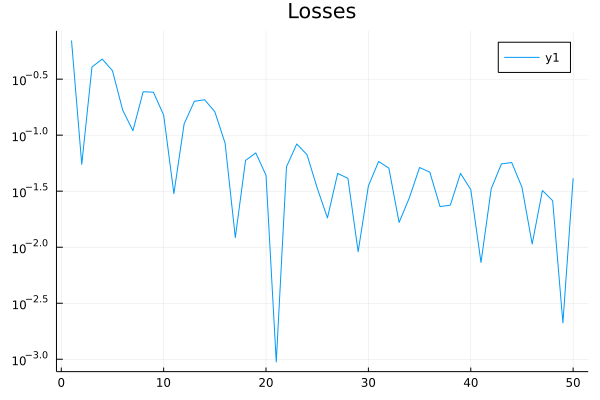

In [28]:
plot(losses, yaxis=:log, title="Losses")

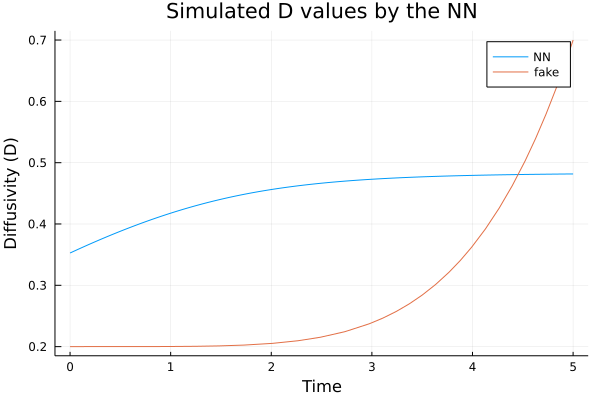

In [29]:
all_times = LinRange(0, t₁, 1000)
plot(all_times, UD_trained(all_times')', title="Simulated D values by the NN", yaxis="Diffusivity (D)", xaxis="Time", label="NN")
plot!(fakeD, 0, t₁, label="fake")

In [ ]:
sqnorm(x) = sum(abs2, x)
sum(sqnorm, Flux.params(UD_trained))

In [ ]:
m = Chain(
  Dense(1, 2, relu),
  Dense(2, 1))

sqnorm(x) = sum(abs2, x)

ps = Flux.params(m)   # new line

loss(x, y) = Flux.Losses.logitcrossentropy(m(x), y) + sum(sqnorm, ps)

gradient(()->loss(rand(1), rand(1)), params(m))